In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv("./data_baru/new_data.csv")
df

,Unnamed: 0,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type,loss_reverse
0,0,15500000.0,1.562500e+07,29500000.0,24350000.0,2.0,1.0,670.0,0.0,DPK,Retired,0.000000e+00
1,1,17500000.0,1.770833e+07,3000000.0,1600000.0,31.0,3.0,402.0,1.0,DPK,Full-time,1.770833e+07
2,2,17500000.0,1.483333e+07,13500000.0,9050000.0,0.0,0.0,505.0,0.0,Lancar,Full-time,0.000000e+00
3,3,15500000.0,1.529167e+07,10500000.0,8350000.0,64.0,5.0,508.0,1.0,DPK,Retired,1.529167e+07
4,4,8700000.0,1.404167e+07,6500000.0,5750000.0,14.0,2.0,371.0,0.0,DPK,Contract,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,15500000.0,2.200000e+07,22000000.0,12900000.0,106.0,7.0,272.0,2.0,Kurang lancar,Retired,4.400000e+07
4996,4996,19000000.0,1.275000e+07,2000000.0,1600000.0,25.0,1.0,464.0,1.0,DPK,Full-time,1.275000e+07
4997,4997,12700000.0,1.537500e+07,10500000.0,10050000.0,53.0,4.0,369.0,1.0,DPK,Contract,1.537500e+07
4998,4998,13700000.0,1.475000e+07,8000000.0,4800000.0,27.0,1.0,266.0,1.0,DPK,Contract,1.475000e+07


In [3]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   net_income                  5000 non-null   float64
 1   loan_amount                 5000 non-null   float64
 2   avg_amounts_previous_bills  5000 non-null   float64
 3   avg_previous_payment        5000 non-null   float64
 4   amount_of_late              5000 non-null   float64
 5   late_payment_amount         5000 non-null   float64
 6   credit_score                5000 non-null   float64
 7   arrears_amounts             5000 non-null   float64
 8   aging                       5000 non-null   object 
 9   employment_type             5000 non-null   object 
 10  loss_reverse                5000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 429.8+ KB


In [5]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")
        


In [6]:
aging = {"Lancar": 0, "DPK": 1, "Kurang lancar": 2, "Diragukan": 3, "Macet": 4}
employment_type = {"Not-employed": 0, "Self-employed": 1, "Internship": 2, "Part-time": 3, "Contract": 4, "Full-time": 5, "Retired": 6}
columns = {"aging" : aging, "employment_type": employment_type}

for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        df[i] = [columns[i][j] for j in df[i]]

y = df["loss_reverse"]
df.drop("loss_reverse", axis=1, inplace=True)             
scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type
0,0.000000,0.190476,1.24,1.431472,-0.800000,-0.6,1.589041,-1.0,1,6
1,0.266667,0.984127,-0.88,-0.878173,-0.413333,-0.2,0.365297,0.0,1,5
2,0.266667,-0.111111,-0.04,-0.121827,-0.826667,-0.8,0.835616,-1.0,0,5
3,0.000000,0.063492,-0.28,-0.192893,0.026667,0.2,0.849315,0.0,1,6
4,-0.906667,-0.412698,-0.60,-0.456853,-0.640000,-0.4,0.223744,-1.0,1,4


In [7]:
X = df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 10), (1000, 10), (4000,), (1000,))

In [8]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mse ** (1/2)
r_square = r2_score(y_test, y_pred)

print(f"""
      Mean Squared Errror : {mse:.2f}
      Mean Absolute Error : {mae:.2f}
      Mean Absolute Percentage Error : {mape:.2f}
      Root Mean Squared Error : {mape:.2f}
      R_Squared : {r_square:.2f}
      """)


      Mean Squared Errror : 2258618793827.09
      Mean Absolute Error : 171252.83
      Mean Absolute Percentage Error : 13979447910983364608.00
      Root Mean Squared Error : 13979447910983364608.00
      R_Squared : 0.99
      


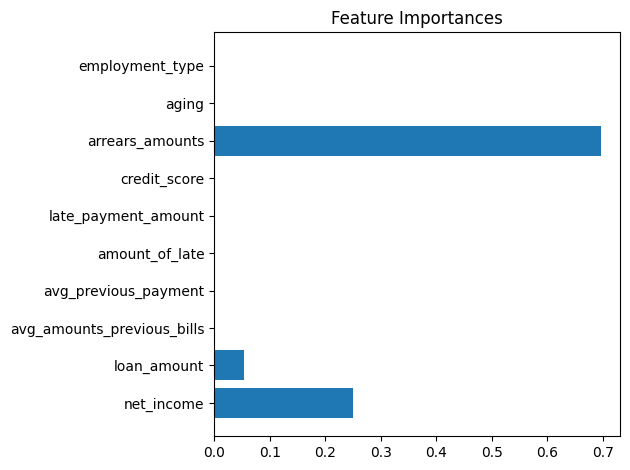

In [10]:
plt.barh(X_train.columns, model.feature_importances_)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

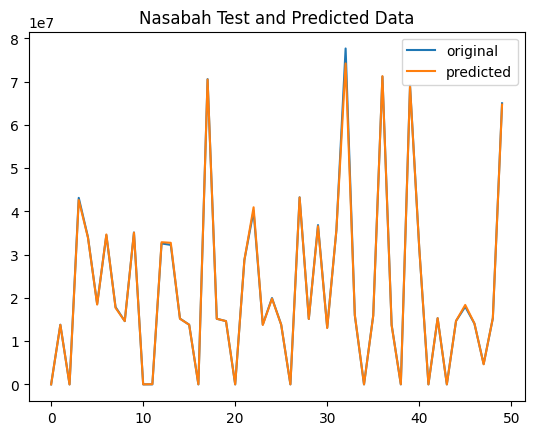

In [11]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], label="original")
plt.plot(x_ax, y_pred[:50], label="predicted")
plt.title("Nasabah Test and Predicted Data")
plt.legend()
plt.show()

In [12]:
import pickle

pickle.dump(model, open("xgb.pkl", "wb"))

In [13]:
X_test

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type
1501,-0.773333,-0.079365,-0.04,0.203046,-0.800000,-0.6,0.547945,-1.0,1,4
2586,0.466667,-0.507937,-0.24,-0.005076,0.493333,0.6,-0.707763,0.0,2,5
2653,1.133333,-1.285714,0.56,0.939086,-0.600000,-0.4,0.305936,-1.0,1,5
1055,0.466667,-0.285714,-0.52,-0.497462,1.013333,0.8,-0.958904,2.0,3,5
705,1.400000,7.206349,1.40,1.055838,-0.200000,-0.4,1.602740,0.0,1,6
...,...,...,...,...,...,...,...,...,...,...
4711,0.466667,-0.460317,-0.84,-0.812183,0.040000,0.2,-0.287671,0.0,1,5
2313,0.933333,0.317460,-0.76,-0.791878,-0.826667,-0.8,1.210046,-1.0,0,5
3214,-0.666667,-0.285714,-0.28,-0.111675,0.266667,0.0,0.662100,0.0,1,4
2732,0.400000,-0.222222,-0.64,-0.644670,-0.573333,-0.6,0.821918,0.0,1,6


In [14]:
X_train

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type
4227,1.400000,7.968254,1.68,0.969543,1.613333,1.4,-0.132420,3.0,4,5
4676,-0.333333,0.095238,-0.24,0.025381,-0.240000,-0.2,0.191781,0.0,1,6
800,0.266667,-0.285714,0.64,0.441624,-0.520000,-0.6,0.767123,0.0,1,5
3671,0.933333,-0.460317,0.44,0.700508,0.333333,0.0,0.009132,1.0,1,5
4193,-2.040000,-3.365079,0.40,0.208122,1.813333,1.2,-1.283105,3.0,4,0
...,...,...,...,...,...,...,...,...,...,...
4426,0.733333,-1.015873,0.28,0.578680,-0.240000,0.2,0.511416,0.0,1,5
466,0.266667,0.079365,0.92,0.497462,0.946667,1.0,-0.657534,0.0,3,5
3092,-0.666667,-0.285714,-0.60,-0.497462,-0.600000,-0.6,0.182648,0.0,1,6
3772,0.333333,1.285714,-0.84,-0.862944,-0.453333,-0.4,0.771689,0.0,1,6


In [15]:
import joblib
load_model = joblib.load('xgb.pkl')

input_data = X_test.iloc[-1]
final_features = [np.array(input_data)]
result = load_model.predict(final_features)[0]
result

ValueError: training data did not have the following fields: net_income, loan_amount, avg_amounts_previous_bills, avg_previous_payment, amount_of_late, late_payment_amount, credit_score, arrears_amounts, aging, employment_type

In [ ]:
y_test.iloc[0]

0.0